# Temperature Statistics for Europe

Deroived from climate projections

This dataset provides temperature exposure statistics for Europe, focusing on daily 2-meter air temperature (mean, minimum, and maximum) for entire years, as well as for winter (DJF) and summer (JJA) seasons. Derived using bias-adjusted EURO-CORDEX data, the statistics span a smoothed 30-year average from 1971 to 2100, resulting in a timeseries from 1986 to 2085, with model ensemble averages and associated standard deviations included. These temperature percentiles are crucial in public health and epidemiology for assessing health risks and impacts, enabling comparisons across regions under various climate change scenarios.

**Information on Dataset:**
* Source: [Temperature Statistics for Europe](https://cds.climate.copernicus.eu/datasets/sis-temperature-statistics?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Resolution: 0.1° x 0.1°
* Notebook Version: 1.1 (Updated: December 17. 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\sis-temperature-statistics\download"
working_folder = r".\data\sis-temperature-statistics\working"
geotiff_folder = r".\data\sis-temperature-statistics\geotiff"
csv_folder = r".\data\sis-temperature-statistics\csv"
output_folder = r".\data\sis-temperature-statistics\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Example: Load shapefile of Konstanz (WGS84 projection)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)
de_bounds = de_gdf.total_bounds

# Adjust and buffer
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
# Define the available options for periods and temperature variables
period_list = ["year", "summer", "winter"]
variable_list = ["average_temperature", "minimum_temperature", "maximum_temperature"]

# Select period and variable for processing; modify these as needed
selected_period = period_list[0]  # Default: "year"
selected_variable = variable_list[0]  # Default: "average_temperature"

# Display the selected variable and period
print(f"Selected Variable: {selected_variable}\nSelected Period: {selected_period}")

# Define statistics based on the selected variable
# For "average_temperature", include additional statistics; otherwise, use only "time_average"
statistic = (
    ['time_average', '10th_percentile', '90th_percentile']
    if selected_variable == "average_temperature"
    else ['time_average']
)

Selected Variable: average_temperature
Selected Period: year


In [5]:
dataset = "sis-temperature-statistics"
request = {
    "variable": selected_variable,
    "period": selected_period,
    "statistic": statistic,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [6]:
# Run this cell to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}_{selected_period}_{selected_variable}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-01-17 14:51:18,732 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.


2025-01-17 14:51:18,732 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-01-17 14:51:18,732 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**


2025-01-17 14:51:18,732 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip folder

In [7]:
import zipfile

extract_folder = os.path.join(working_folder, selected_period)
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
try:  
    if not os.listdir(extract_folder):
        for variable in variable_list:
            dataset_filename = f"{dataset}_{selected_period}_{variable}.zip"
            dataset_filepath = os.path.join(download_folder, dataset_filename)
            
            with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
                print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF file and print the metadata

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Important</span>: After downloading the datasets, update the **selected_period** in the code block below to proceed with analysis, data extraction, and visualization.

In [8]:
# Modify the selected period here
selected_period = period_list[1] # 0: year, 1: summer, 2: winter
print(selected_period)

extract_folder = os.path.join(working_folder, selected_period)

summer


In [9]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    match = re.search(r'(mean|p10|p90)_(Tmean|Tmax|Tmin)_(Yearly|Winter|Summer)_(rcp\d{2})_(mean|stdev)_v(\d+\.\d+)\.', filename)
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
    
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]
    
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_period=match.group(3),
        ds_variable=match.group(2),
        ds_statistic=match.group(1),
        variable_name=get_nc_variable(),
        rcp=match.group(4),
        rcp_statistic=match.group(5),
    )

# Beispielverzeichnis (angepasst an deine Umgebung)
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
nc_files_sorted = sorted(nc_files, key=lambda x: (x['ds_variable'], x['ds_statistic']))

df_nc_files = pd.DataFrame.from_dict(nc_files_sorted)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame without displaying path
df_nc_files.loc[:, df_nc_files.columns != 'path']

,filename,ds_period,ds_variable,ds_statistic,variable_name,rcp,rcp_statistic
0,mean_Tmax_Summer_rcp45_mea...,Summer,Tmax,mean,mean_Tmax_Summer,rcp45,mean
1,mean_Tmax_Summer_rcp45_std...,Summer,Tmax,mean,mean_Tmax_Summer,rcp45,stdev
2,mean_Tmax_Summer_rcp85_mea...,Summer,Tmax,mean,mean_Tmax_Summer,rcp85,mean
3,mean_Tmax_Summer_rcp85_std...,Summer,Tmax,mean,mean_Tmax_Summer,rcp85,stdev
4,mean_Tmean_Summer_rcp45_me...,Summer,Tmean,mean,mean_Tmean_Summer,rcp45,mean
5,mean_Tmean_Summer_rcp45_st...,Summer,Tmean,mean,mean_Tmean_Summer,rcp45,stdev
6,mean_Tmean_Summer_rcp85_me...,Summer,Tmean,mean,mean_Tmean_Summer,rcp85,mean
7,mean_Tmean_Summer_rcp85_st...,Summer,Tmean,mean,mean_Tmean_Summer,rcp85,stdev
8,p10_Tmean_Summer_rcp45_mea...,Summer,Tmean,p10,p10_Tmean_Summer,rcp45,mean
9,p10_Tmean_Summer_rcp45_std...,Summer,Tmean,p10,p10_Tmean_Summer,rcp45,stdev


### 3.1 Short info on downloaded data structure

The diagram shows the structure of **sis-temperature-statistics** data. It is organized into four levels:

1. **Period**: Represents the time unit (e.g., year, summer or winter).

2. **Variable**: Three variables:
    - **Average Temperature**  
    - **Minimum Temperature**  
    - **Maximum Temperature**

3. **Statistic**: For each variable, specific statistics are calculated:
    - **Time Average**  
    - **10th Percentile** (for Average Temperature Only)  
    - **9th Percentile** (for Average Temperature Only)

4. **Experiment**: Data is provided under two climate scenarios:
    - **rcp45**
    - **rcp85**
    - For each experiment:  
        - rep45_mean, rcp45_std
        - rep85_mean, rcp85_std

The diagram flows from **Period** to **Variable**, then to **Statistic**, and finally to **Experiment** outputs. It shows how temperature data is structured and analyzed.

<img src="./images/sis-temperature-statistics-data-structure_v2.jpg" width="550" style="display: block; margin: 0 auto; border: 1px solid #aeaeae">

In [10]:
import netCDF4 as nc

seen_variables = set()
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # List all variables in the dataset
    variables_list = nc_dataset.variables.keys()
    print(f"{i+1:<2} {variable_name:<17}: Available variables: {list(variables_list)}")
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)

1  mean_Tmax_Summer : Available variables: ['mean_Tmax_Summer', 'height', 'lat', 'lon', 'time']
5  mean_Tmean_Summer: Available variables: ['mean_Tmean_Summer', 'height', 'lat', 'lon', 'time']
9  mean_Tmin_Summer : Available variables: ['mean_Tmin_Summer', 'height', 'lat', 'lon', 'time']
13 p10_Tmean_Summer : Available variables: ['p10_Tmean_Summer', 'quantile', 'lat', 'lon', 'time']
17 p90_Tmean_Summer : Available variables: ['p90_Tmean_Summer', 'quantile', 'lat', 'lon', 'time']


In [11]:
seen_variables = set()
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    if variable_name in seen_variables:
        continue
    
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')
    variable_data = nc_dataset[variable_name]
    
    # Generate summary of the primary variable
    summary = {
        "Variable Name": variable_name,
        "Data Type": variable_data.dtype,
        "Shape": variable_data.shape,
        "Variable Info": f"{variable_data.dimensions}",
        "Units": getattr(variable_data, "units", "N/A"),
        "Long Name": getattr(variable_data, "long_name", "N/A"),
    }
    
    # Display dataset summary as a DataFrame for better visualization
    nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

    # Display the summary DataFrame
    print(f"{i+1}.")
    display(nc_summary)
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)
    if len(seen_variables)>=2:
        print("....")
        break

1.


,Description,Remarks
0,Variable Name,mean_Tmax_Summer
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info,"('time', 'lat', 'lon')"
4,Units,degrees C
5,Long Name,Ensemble members average o...


5.


,Description,Remarks
0,Variable Name,mean_Tmean_Summer
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info,"('time', 'lat', 'lon')"
4,Units,degrees C
5,Long Name,Ensemble members average o...


....


## 4. Export Dataset to CSV

In [12]:
import numpy as np
import netCDF4 as nc

def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):
    """
    Converts a netCDF file to a DataFrame, optionally filtering by a bounding box.

    Parameters:
        nc_file (dict): Dictionary with keys.
        bbox (list): Bounding box as [lon_min, lat_min, lon_max, lat_max] (optional).

    Returns:
        pd.DataFrame: DataFrame with time, latitude, longitude, and the variable's values.
    """
    # Open the netCDF file
    nc_dataset = nc.Dataset(nc_file['path'], 'r')
    lon = nc_dataset['lon'][:]
    lat = nc_dataset['lat'][:]
    
    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = time_var.units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

    # Extract temperature/variable data
    variable_data = nc_dataset.variables[nc_file['variable_name']]
    
    # Filter by bounding box if provided
    if bounding_box:
        lon_min, lat_min, lon_max, lat_max = bounding_box
        
        indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
        indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        
        start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
        start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        
        filtered_lat = lat[start_lat:end_lat]
        filtered_lon = lon[start_lon:end_lon]
        variable_data_subset = variable_data[:, start_lat:end_lat, start_lon:end_lon]
    else:
        filtered_lat = lat
        filtered_lon = lon
        variable_data_subset = variable_data        
            
    # Create a column name for the variable
    variable_column_name = f"{nc_file['ds_period']}_{nc_file['ds_variable']}_{nc_file['ds_statistic']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
    print(variable_column_name)
    
    # Create rows for the DataFrame
    rows = []
    for t in range(variable_data_subset.shape[0]):
        for i in range(variable_data_subset.shape[1]):
            for j in range(variable_data_subset.shape[2]):
                if not np.ma.is_masked(variable_data_subset[t, i, j]):
                    rows.append({
                        'time': cftime[t],
                        'latitude': filtered_lat[i],
                        'longitude': filtered_lon[j],
                        variable_column_name: variable_data_subset[t, i, j]
                    })

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    df['time'] = pd.to_datetime(df['time'].map(str))
    df['latitude'] = pd.to_numeric(df['latitude'])
    df['longitude'] = pd.to_numeric(df['longitude'])
    df[variable_column_name] = pd.to_numeric(df[variable_column_name])
    
    # Set the index to time, latitude, and longitude
    return df.set_index(['time', 'latitude', 'longitude'])

In [13]:
# Gpt optimized
import numpy as np
import pandas as pd
import netCDF4 as nc

def netcdf_to_dataframe(nc_file, bounding_box=None):
    """
    Converts a netCDF file to a DataFrame, optionally filtering by a bounding box.
    
    Parameters:
        nc_file (dict): Dictionary with keys.
        bounding_box (list): Bounding box as [lon_min, lat_min, lon_max, lat_max] (optional).
        
    Returns:
        pd.DataFrame: DataFrame with time, latitude, longitude, and the variable's values.
    """
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
        
        # Extract time and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        # Extract variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]

        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            lat_mask = (lat >= lat_min) & (lat <= lat_max)
            lon_mask = (lon >= lon_min) & (lon <= lon_max)

            lat_indices = np.where(lat_mask)[0]
            lon_indices = np.where(lon_mask)[0]

            filtered_lat = lat[lat_indices]
            filtered_lon = lon[lon_indices]
            variable_data_subset = variable_data[:, lat_indices, :][:, :, lon_indices]
        else:
            filtered_lat = lat
            filtered_lon = lon
            variable_data_subset = variable_data[:]

    # Flatten the data using NumPy
    time_size, lat_size, lon_size = variable_data_subset.shape
    variable_column_name = f"{nc_file['ds_period']}_{nc_file['ds_variable']}_{nc_file['ds_statistic']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
    
    # Masked values will be excluded automatically
    masked_data = variable_data_subset.filled(np.nan)  # Fill masked values with NaN
    valid_mask = ~np.isnan(masked_data)

    # Generate time, latitude, longitude mesh grids
    time_grid, lat_grid, lon_grid = np.meshgrid(
        cftime, filtered_lat, filtered_lon, indexing='ij'
    )

    # Extract valid (non-NaN) data
    time_flat = time_grid[valid_mask]
    lat_flat = lat_grid[valid_mask]
    lon_flat = lon_grid[valid_mask]
    values_flat = masked_data[valid_mask]

    # Construct a DataFrame
    df = pd.DataFrame({
        'time': time_flat,
        'latitude': lat_flat,
        'longitude': lon_flat,
        variable_column_name: values_flat
    })

    # Convert time to datetime
    df['time'] = pd.to_datetime(df['time'].astype(str))

    # Set the index
    return df.set_index(['time', 'latitude', 'longitude'])


### 4.1 Create DataFrame and Export as merged CSV file

In [14]:
from tqdm.notebook import tqdm
import textwrap

csv_filename = f"sis-temperature-statistics-{nc_files_sorted[0]['ds_period']}.csv.zip"
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files_sorted)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Modify pandas display options
pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.2f}'.format
    
# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=11)
df_wrapped

File already exists at .\data\sis-temperature-statistics\csv\sis-temperature-statistics-Summer.csv.zip. Skipping export.


Summer_Tmax _mean_rcp45 _mean  \
time       latitude longitude                                  
1986-06-01 47.10    5.70                               24.18   
                    5.80                               23.92   
                    5.90                               23.34   
                    6.00                               22.82   
                    6.10                               22.25   
...                                                      ...   
2085-06-01 55.20    14.70                              23.74   
                    14.80                              24.18   
                    14.90                              24.30   
                    15.00                              24.22   
                    15.10                              24.11   

                               Summer_Tmax _mean_rcp45 _stdev  \
time       latitude longitude                                   
1986-06-01 47.10    5.70                                0.20    
                    5.80                                0.23    
                    5.90                                0.23    
                    6.00                                0.20    
                    6.10                                0.21    
...                                                      ...    
2085-06-01 55.20    14.70                               0.72    
                    14.80                               0.81    
                    14.90                               0.82    
                    15.00                               0.67    
                    15.10                               0.75    

                               Summer_Tmax _mean_rcp85 _mean  \
time       latitude longitude                                  
1986-06-01 47.10    5.70                               24.18   
                    5.80                               23.92   
                    5.90                               23.34   
                    6.00                               22.82   
                    6.10                               22.25   
...                                                      ...   
2085-06-01 55.20    14.70                              24.96   
                    14.80                              25.41   
                    14.90                              25.56   
                    15.00                              25.47   
                    15.10                              25.32   

                               Summer_Tmax _mean_rcp85 _stdev  \
time       latitude longitude                                   
1986-06-01 47.10    5.70                                0.19    
                    5.80                                0.21    
                    5.90                                0.22    
                    6.00                                0.18    
                    6.10                                0.18    
...                                                      ...    
2085-06-01 55.20    14.70                               0.70    
                    14.80                               0.80    
                    14.90                               0.80    
                    15.00                               0.65    
                    15.10                               0.69    

                               Summer_Tmea n_mean_rcp4 5_mean  \
time       latitude longitude                                   
1986-06-01 47.10    5.70                               18.79    
                    5.80                               18.59    
                    5.90                               18.15    
                    6.00                               17.63    
                    6.10                               17.12    
...                                                      ...    
2085-06-01 55.20    14.70                              18.65    
                    14.80                              18.67    
                    14.

### 4.2 Filter by Area, Create DataFrame and Export as merged CSV file

In [15]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding box for the Konstanz region (WGS84 projection):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [North, West, South, East]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

csv_filename = f"sis-temperature-statistics-subset-{nc_files_sorted[0]['ds_period']}.csv.zip"
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard) for nc_file in tqdm(nc_files_sorted)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=11)
df_wrapped

File already exists at .\data\sis-temperature-statistics\csv\sis-temperature-statistics-subset-Summer.csv.zip. Skipping export.


Summer_Tmax _mean_rcp45 _mean  \
time       latitude longitude                                  
1986-06-01 47.60    9.00                               23.73   
                    9.10                               23.87   
                    9.20                               23.82   
           47.70    9.00                               23.96   
                    9.10                               24.20   
...                                                      ...   
2085-06-01 47.70    9.10                               26.26   
                    9.20                               26.31   
           47.80    9.00                               24.98   
                    9.10                               25.38   
                    9.20                               25.37   

                               Summer_Tmax _mean_rcp45 _stdev  \
time       latitude longitude                                   
1986-06-01 47.60    9.00                                0.43    
                    9.10                                0.44    
                    9.20                                0.37    
           47.70    9.00                                0.31    
                    9.10                                0.36    
...                                                      ...    
2085-06-01 47.70    9.10                                0.84    
                    9.20                                0.84    
           47.80    9.00                                0.69    
                    9.10                                0.68    
                    9.20                                0.64    

                               Summer_Tmax _mean_rcp85 _mean  \
time       latitude longitude                                  
1986-06-01 47.60    9.00                               23.73   
                    9.10                               23.87   
                    9.20                               23.82   
           47.70    9.00                               23.96   
                    9.10                               24.20   
...                                                      ...   
2085-06-01 47.70    9.10                               28.28   
                    9.20                               28.32   
           47.80    9.00                               27.00   
                    9.10                               27.41   
                    9.20                               27.38   

                               Summer_Tmax _mean_rcp85 _stdev  \
time       latitude longitude                                   
1986-06-01 47.60    9.00                                0.37    
                    9.10                                0.38    
                    9.20                                0.32    
           47.70    9.00                                0.26    
                    9.10                                0.30    
...                                                      ...    
2085-06-01 47.70    9.10                                1.35    
                    9.20                                1.34    
           47.80    9.00                                1.19    
                    9.10                                1.14    
                    9.20                                1.09    

                               Summer_Tmea n_mean_rcp4 5_mean  \
time       latitude longitude                                   
1986-06-01 47.60    9.00                               18.57    
                    9.10                               18.73    
                    9.20                               18.77    
           47.70    9.00                               18.74    
                    9.10                               18.96    
...                                                      ...    
2085-06-01 47.70    9.10                               21.07    
                    9.20                               21.17    
           47.80    9.0

## 5. Export Dataset to GeoTIFF

### 5.1 Function to exort the Dataset as GeoTIFF File(s)

In [16]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
    
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extract time variable and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Compute spatial resolution and raster transformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Determine the time range
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Adjust start_year and end_year based on the available cftime range
            if start_year < min_year:
                print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
            if end_year > max_year:
                print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)

            dt_full_start = start_year
            dt_full_end = end_year
        else:
            # Default to the full dataset
            dt_full_start = min_year
            dt_full_end = max_year
            start_year = min_year
            end_year = max_year
            
        # Find indices corresponding to the specified year range
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 # Year
        
        # Extract temperature/variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index,
                                            start_lat:end_lat,
                                            start_lon:end_lon]
        
        # Create subset directory name based on the nc_file
        nc_filename = f"{nc_file['ds_statistic']}_{nc_file['ds_variable']}_{nc_file['ds_period']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        if f"{nc_file['ds_variable']}" == "Tmax":
            period_sub_directory = "Maximum temperature"
        elif f"{nc_file['ds_variable']}" == "Tmean":
            period_sub_directory = "Average temperature"
        elif f"{nc_file['ds_variable']}" == "Tmin":
            period_sub_directory = "Minimum temperature"
            
        if merged:
            # Create a merged GeoTIFF containing all time slices as separate bands
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)

            output_filename = f"{nc_filename}-merged-{dt_full_start}-{dt_full_end}.tif"
            output_filepath = os.path.join(save_directory_path, output_filename)

            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Write each year slice as a band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exporting individual GeoTIFF files"):
                # Retrieve the date for the current time slice
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Define the output GeoTIFF file path            
                output_filename = f"{nc_filename}_{dt_full}.tif"
                output_filepath = os.path.join(save_directory_path, output_filename)

                # Export the current time slice as a GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Export selected dataset to GeoTIFF

In [17]:
# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
# If same start and end year is used for export, then old GeoTIFF file will be replaced.

if __name__ == "__main__":
    # Export all merged
    for nc_file in nc_files:
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=None,
                            merged=True) # Merged GeoTIFF

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
# # Uncomment and run this code to save individual GeoTIFF files

# if __name__ == "__main__":
#     # Export all individual
#     for nc_file in nc_files:
#         main_export_geotiff(nc_file=nc_file,
#                             bounding_box=None,
#                             merged=False) # Individual GeoTIFF

In [19]:
if __name__ == "__main__":
    # Additional case (Advanced filtering)
    temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    os.makedirs(temp_folder, exist_ok=True)
    
    main_export_geotiff(nc_file=nc_file,
                        bounding_box=bbox_wgs84_konstanz_standard,
                        start_year=2000,
                        end_year=2020,
                        merged=True,
                        output_directory=temp_folder) # Merged, Date filtered and Area filtered

Exporting merged GeoTIFF file from 2000 to 2020:   0%|          | 0/21 [00:00<?, ?it/s]

## 6. Plot using Matplotlib

In [20]:
import matplotlib.pyplot as plt

lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# Filter the dataframe with query
filtered_df = (
    df_merged.query(
        "@lat_min <= latitude <= @lat_max and @lon_min <= longitude <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df, width=11)
df_wrapped.head()

,latitude,longitude,Summer_Tmax _mean_rcp45 _mean,Summer_Tmax _mean_rcp45 _stdev,Summer_Tmax _mean_rcp85 _mean,Summer_Tmax _mean_rcp85 _stdev,Summer_Tmea n_mean_rcp4 5_mean,Summer_Tmea n_mean_rcp4 5_stdev,Summer_Tmea n_mean_rcp8 5_mean,Summer_Tmea n_mean_rcp8 5_stdev,...,Summer_Tmea n_p10_rcp85 _mean,Summer_Tmea n_p10_rcp85 _stdev,Summer_Tmea n_p90_rcp45 _mean,Summer_Tmea n_p90_rcp45 _stdev,Summer_Tmea n_p90_rcp85 _mean,Summer_Tmea n_p90_rcp85 _stdev,Summer_Tmin _mean_rcp45 _mean,Summer_Tmin _mean_rcp45 _stdev,Summer_Tmin _mean_rcp85 _mean,Summer_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,,
1986-06-01,47.60,9.00,23.73,0.43,23.73,0.37,18.57,0.32,18.57,0.27,...,13.88,0.35,23.14,0.34,23.14,0.31,13.26,0.29,13.26,0.27
1986-06-01,47.60,9.10,23.87,0.44,23.87,0.38,18.73,0.33,18.73,0.28,...,14.02,0.37,23.31,0.36,23.31,0.33,13.43,0.29,13.43,0.26
1986-06-01,47.60,9.20,23.82,0.37,23.82,0.32,18.77,0.28,18.77,0.24,...,14.09,0.33,23.31,0.35,23.31,0.34,13.51,0.23,13.51,0.21
1986-06-01,47.70,9.00,23.96,0.31,23.96,0.26,18.74,0.24,18.74,0.20,...,14.06,0.31,23.23,0.26,23.23,0.24,13.35,0.30,13.35,0.29
1986-06-01,47.70,9.10,24.20,0.36,24.20,0.30,18.96,0.29,18.96,0.25,...,14.27,0.34,23.49,0.32,23.49,0.28,13.56,0.31,13.56,0.29


In [21]:
# Group by the 'time' index and calculate the mean for each group
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['latitude', 'longitude'])

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df_average, width=11)
df_wrapped

,Summer_Tmax _mean_rcp45 _mean,Summer_Tmax _mean_rcp45 _stdev,Summer_Tmax _mean_rcp85 _mean,Summer_Tmax _mean_rcp85 _stdev,Summer_Tmea n_mean_rcp4 5_mean,Summer_Tmea n_mean_rcp4 5_stdev,Summer_Tmea n_mean_rcp8 5_mean,Summer_Tmea n_mean_rcp8 5_stdev,Summer_Tmea n_p10_rcp45 _mean,Summer_Tmea n_p10_rcp45 _stdev,Summer_Tmea n_p10_rcp85 _mean,Summer_Tmea n_p10_rcp85 _stdev,Summer_Tmea n_p90_rcp45 _mean,Summer_Tmea n_p90_rcp45 _stdev,Summer_Tmea n_p90_rcp85 _mean,Summer_Tmea n_p90_rcp85 _stdev,Summer_Tmin _mean_rcp45 _mean,Summer_Tmin _mean_rcp45 _stdev,Summer_Tmin _mean_rcp85 _mean,Summer_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,
1986-06-01,23.71,0.35,23.71,0.30,18.60,0.31,18.60,0.28,13.93,0.36,13.93,0.36,23.10,0.35,23.10,0.33,13.33,0.35,13.33,0.33
1987-06-01,23.72,0.35,23.72,0.30,18.62,0.31,18.62,0.28,13.94,0.36,13.94,0.36,23.11,0.35,23.11,0.33,13.35,0.35,13.35,0.33
1988-06-01,23.75,0.35,23.75,0.30,18.64,0.31,18.64,0.28,13.95,0.36,13.95,0.36,23.15,0.35,23.15,0.33,13.38,0.35,13.38,0.33
1989-06-01,23.73,0.35,23.73,0.30,18.64,0.31,18.64,0.28,13.94,0.36,13.94,0.36,23.15,0.35,23.15,0.33,13.38,0.35,13.38,0.33
1990-06-01,23.75,0.35,23.75,0.30,18.66,0.31,18.66,0.28,13.95,0.36,13.95,0.36,23.19,0.35,23.19,0.33,13.41,0.35,13.41,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081-06-01,25.77,0.80,27.61,1.31,20.68,0.64,22.45,0.98,15.67,0.67,16.95,0.77,25.60,0.63,27.77,1.19,15.46,0.58,17.17,0.72
2082-06-01,25.79,0.80,27.64,1.31,20.69,0.64,22.47,0.98,15.68,0.67,16.97,0.77,25.62,0.63,27.81,1.19,15.47,0.58,17.21,0.72
2083-06-01,25.82,0.80,27.67,1.31,20.73,0.64,22.51,0.98,15.74,0.67,17.00,0.77,25.64,0.63,27.84,1.19,15.50,0.58,17.25,0.72


In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Helper function to plot mean lines with shaded area."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for variable_name in variable_name_list:
    # Create the plot:
        # Plot data for rcp45
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            line_color='#1f77b4',
            fill_color='#aec7e8',
            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Plot data for rcp85
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            line_color='#ff7f0e',
            fill_color='#ffbb78',
            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )
        
        # Interval
        interval = 1

        # Set the Y-axis range dynamically
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval

        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # Adjust x-ticks for better readability
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"Average {variable_name.split('_')[0]} temperature \n(Comparing RCP 4.5 and RCP 8.5 Scenarios)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Add description and source
    plt.figtext(
        0.5,
        -0.075,
        (
            'Beschreibung: Durchschnittliche Lufttemperatur pro Jahr, die in einer Höhe von 2 m über der Oberfläche gilt.\n'
            'Source: Quelle: Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019):\n'
            'Temperature statistics for Europe derived from climate projection.\n'
            'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Accessed on 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legend adjustments
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

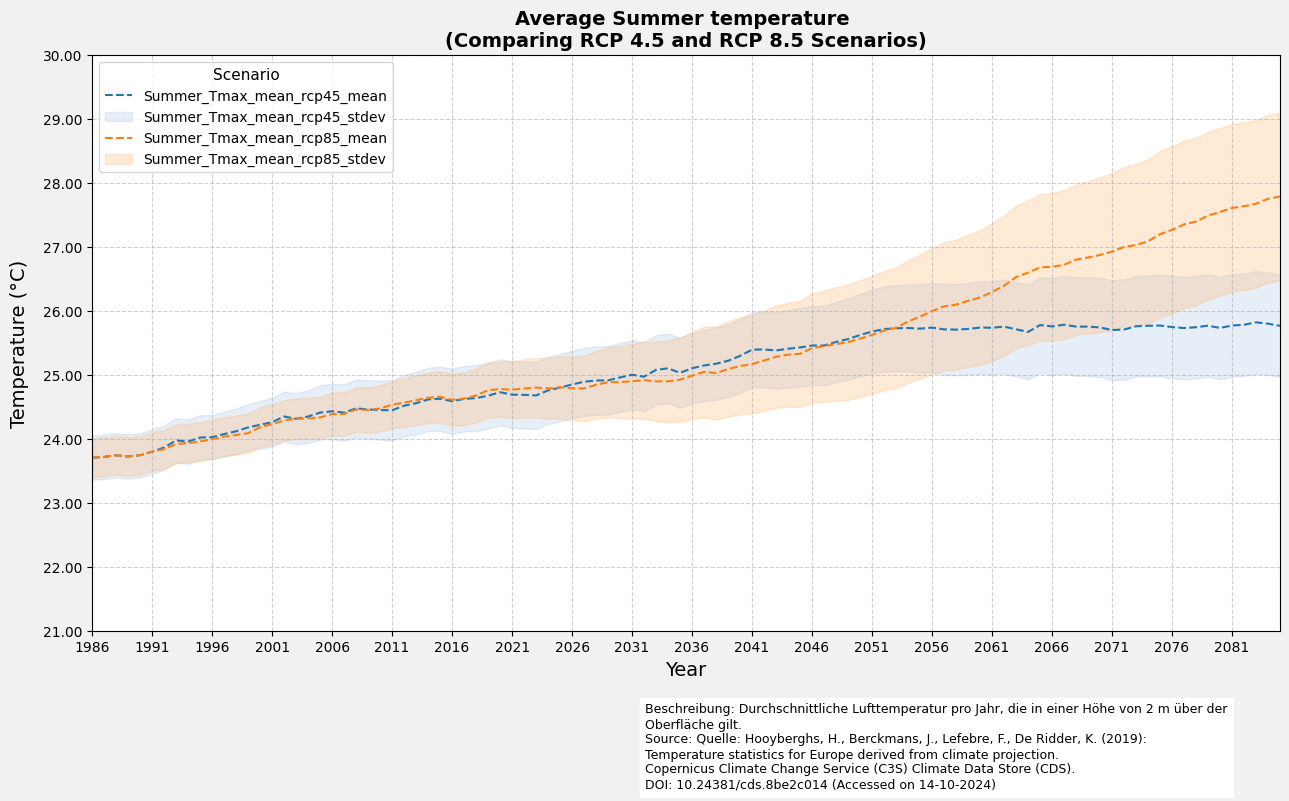

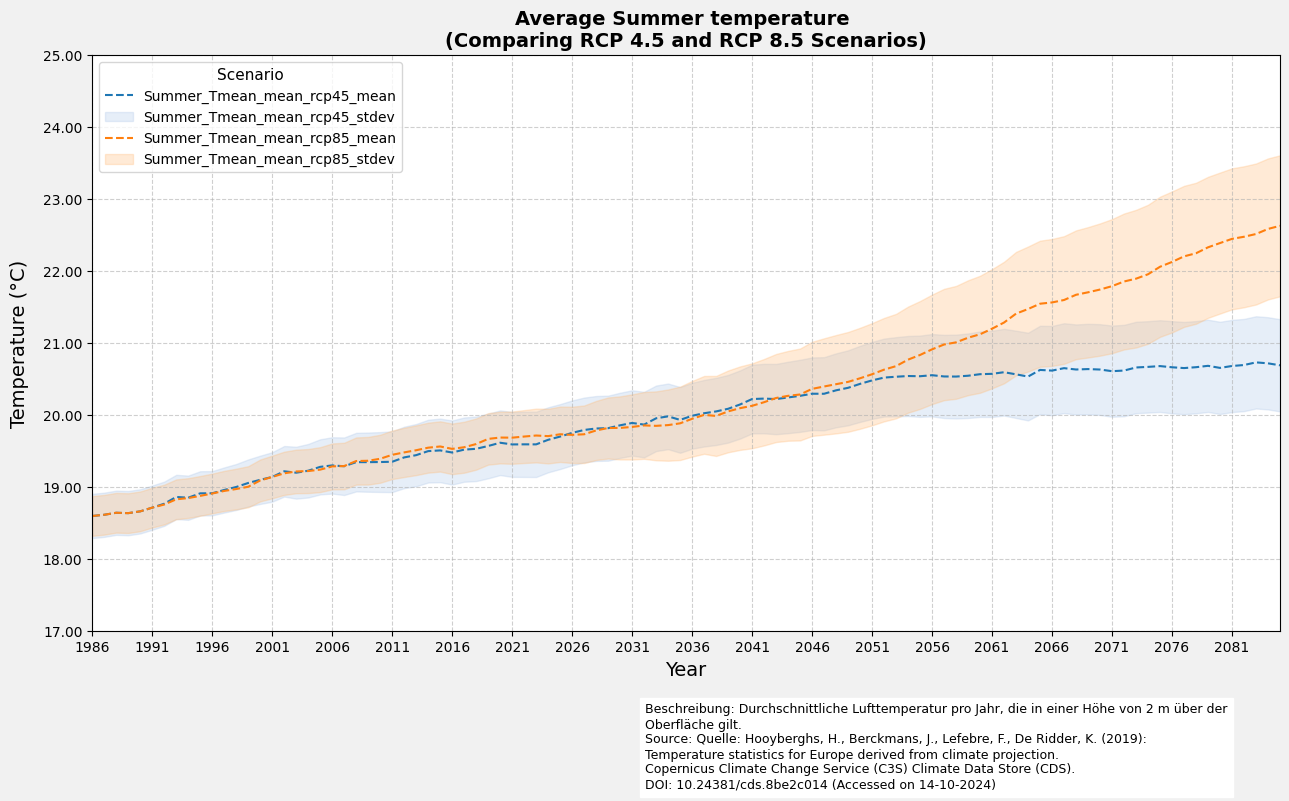

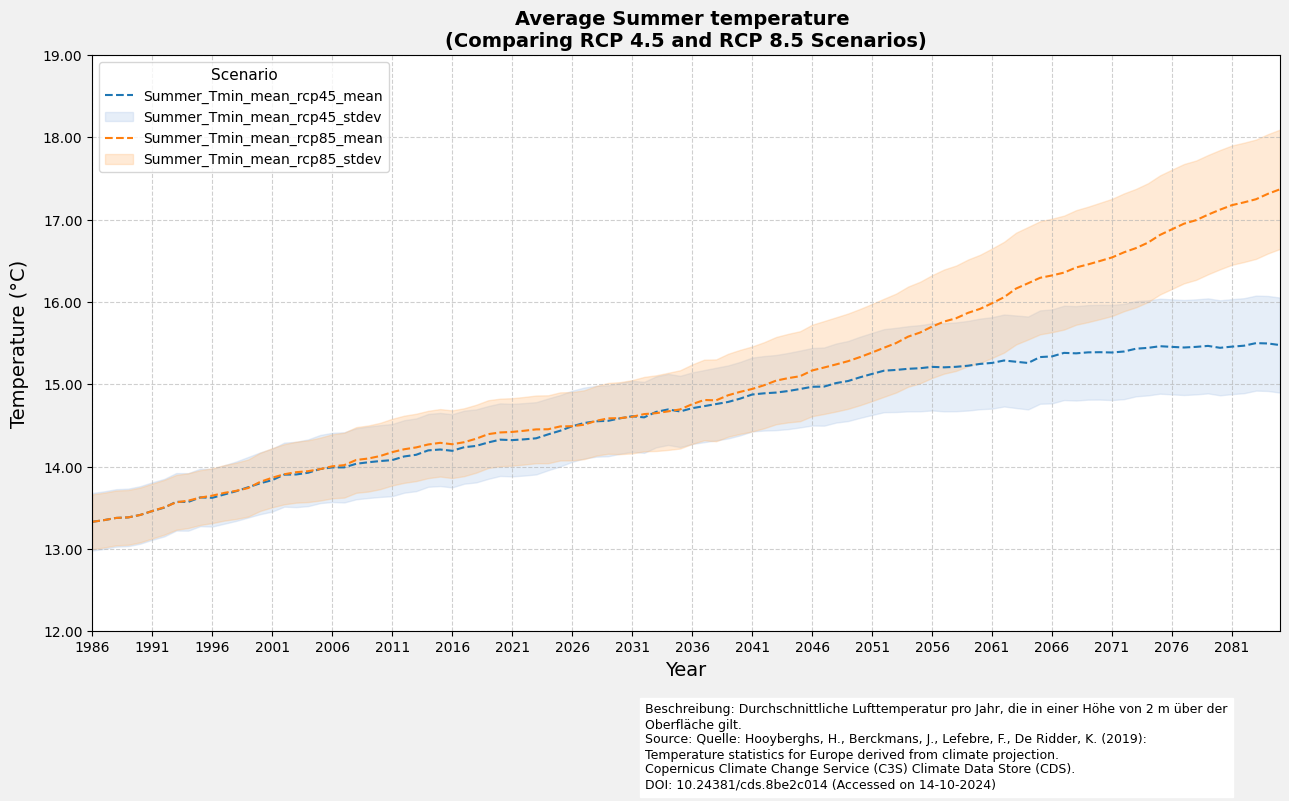

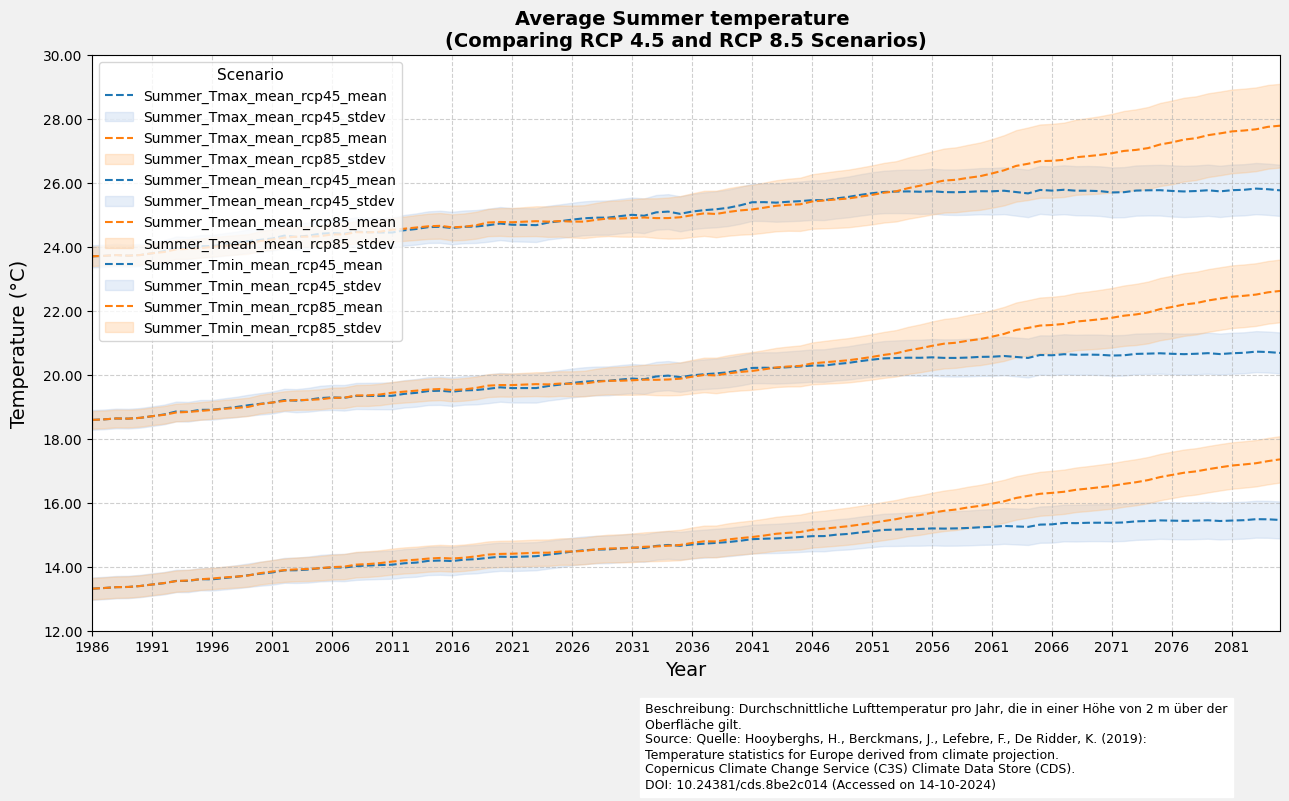

In [23]:
if __name__ == "__main__":
    # Single dataset variable
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files_sorted[0]['ds_period']}_Tmax_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files_sorted[0]['ds_period']}_Tmean_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files_sorted[0]['ds_period']}_Tmin_mean"])
    # Multiple dataset variable
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files_sorted[0]['ds_period']}_Tmax_mean", f"{nc_files_sorted[0]['ds_period']}_Tmean_mean", f"{nc_files_sorted[0]['ds_period']}_Tmin_mean"])
    